In [1]:
%matplotlib inline
import sys
sys.path = ['/home/rch/git/bmcs'] + sys.path
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

## Define the damage functions

\begin{align}
1 - \frac{f_t}{E \varepsilon} \exp(-\frac{f_t}{G_f} (\varepsilon - \varepsilon_0) L_s )
\end{align}

In [2]:
from ibvpy.mats.mats_damage_fn import \
    IDamageFn, LiDamageFn, JirasekDamageFn, AbaqusDamageFn,\
    PlottableFn, DamageFn, GfDamageFn
from traits.api import Float, Property
from traitsui.api import View, Item, VGroup, UItem

In [3]:
f_t = 2.4
G_f = 0.090
E = 30000.0

In [7]:
omega_fn = GfDamageFn(G_f=G_f, f_t=f_t, L_s=1)

In [8]:
eps = np.array([0.00013033], dtype=np.float_)
omega_fn.trait_set(L_s = 10)
omega = omega_fn(eps)
sig = (1 - omega) * E * eps
eps, omega, sig, omega_fn.f_t, omega_fn.eps_0, omega_fn.L_s, omega_fn.G_f

(array([0.00013033]),
 array([0.46694856]),
 array([2.08417784]),
 2.4,
 7.058823529411764e-05,
 10.0,
 0.09)

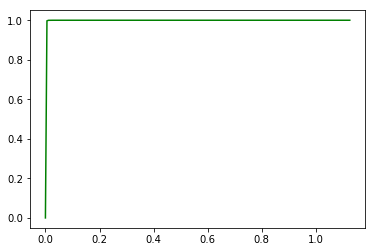

In [9]:
ax = plt.subplot(111)
omega_fn.plot(ax)

## Nonlinear solver

In [15]:
eps_0 = f_t / E
eps_ch = G_f / f_t
L_ch = E * G_f / f_t**2

print('eps_0', eps_0)
print( 'L_ch', L_ch)

L = 200.0
u_max = 0.2
eps_max = eps_ch
eps = np.linspace(0, eps_max, 4)

omega_fn_abaqus = AbaqusDamageFn(s_0=eps_0, s_u=0.03)

n_T = 50
K_max = 200

for N in [2,4,6]:
    sig_t = []
    eps_t = []
    L_el = (N - 1.0) / N * L
    L_s = 10#1.0 / N * L
    eps_s = 0.0
    eps_s_arr = np.array([eps_s], dtype=np.float_)
    u_t = np.linspace(0, u_max, n_T)
    #omega_fn.L_s = L_s
    print('elem size', L_s)
    for u in u_t:
        print('=== increment %g ' % u,)
        for K in range(K_max):
            omega = omega_fn(eps_s_arr)
            eps_s = eps_s_arr[0]
            u_s = eps_s * L_s
            u_el = u - u_s
            R = 1 / L_el * (u - eps_s_arr * L_s) - \
                (1 - omega) * eps_s_arr
            if np.fabs(R) < 1e-8:
                print('converged in %d iterations' % K)
                break
            dR = -L_s / L_el + omega_fn.diff(eps_s_arr) * \
                eps_s_arr - (1 - omega_fn(eps_s_arr))
            d_eps_s = -R / dR
            eps_s_arr += d_eps_s
            if K == K_max - 1:
                raise ValueError('No convergence')
        sig = ((1.0 - omega_fn(eps_s_arr)) * E * eps_s_arr)[0]
        sig_t.append(sig)
        eps_t.append(u)
    plt.plot(eps_t, sig_t)
plt.show();

eps_0 7.999999999999999e-05
L_ch 468.75
elem size 10
=== increment 0 


/home/rch/.local/share/canopy/edm/envs/User/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in multiply
/home/rch/.local/share/canopy/edm/envs/User/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply


ValueError: No convergence

In [ ]:
u_t